In [133]:
%matplotlib inline
import scipy as sp
from scipy.interpolate import interp1d
import iminuit
from matplotlib.pyplot import errorbar, plot, contourf, hist2d
from scipy import random
import emcee
import corner

<Container object of 3 artists>

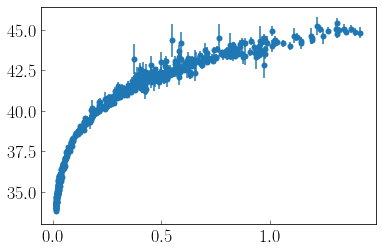

In [2]:
data=loadtxt('data/SCPUnion2.1_mu_vs_z.txt',usecols=(1,2,3))
z = data[:,0]
M = data[:,1]
dM = data[:,2]
## plot data:
errorbar(z, M, yerr = dM, fmt = "o")

In [3]:
def hubble(z, H0, Om, OL):
    return H0*sp.sqrt(Om*(1+z)**3 + OL + (1-Om-OL)*(1+z)**2)

In [68]:
nbins=10000
zmax = 2.
zs = sp.arange(nbins, dtype=float)/(nbins-1)*zmax
dz = zmax/nbins
c = 300000. ## km/s
def D_L(H0, Om, OL):
    chi = (dz*H0/hubble(zs, H0, Om, OL)).cumsum()
    chi = interp1d(zs, chi)(z)
    Ok = 1-Om-OL
    if Ok==0:
        return c/H0*(1+z)*chi
    if Ok > 0:
        return c/H0*(1+z)*sp.sinh(sp.sqrt(Ok)*chi)/sp.sqrt(Ok)
    if Ok<0:
        return c/H0*(1+z)*sp.sin(sp.sqrt(-Ok)*chi)/sp.sqrt(-Ok)
    

In [69]:
## distance modulus
def mu(H0, Om, OL):
    d_pc = D_L(H0, Om, OL)*1e6
    return 5*sp.log10(d_pc)-5

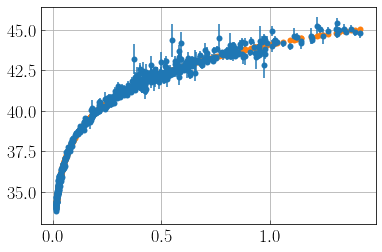

In [70]:
errorbar(z, M, yerr = dM, fmt = "o")
plot(z, mu(70., 0.3, 0.7),"o")
grid()

In [71]:
def chi2(H0, Om, OL):
    res = (M - mu(H0, Om, OL))/dM
    return (res**2).sum()

In [72]:
mig = iminuit.Minuit(chi2, H0=70., Om=0.3, 
        OL=0.7, error_H0=1, error_Om=0.1, error_OL=0.1,
        errordef=1, fix_H0=True, limit_Om=(0,1), limit_OL=(0,1))

In [73]:
fmin = mig.migrad()

FCN = 563.420174145 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 2.11618489812e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,H0,70,1,0,0,,,FIXED
2,Om,0.261346,0.0634262,0,0,0.0,1.0,
3,OL,0.691299,0.0825785,0,0,0.0,1.0,


In [74]:
nOm = 40
Om = 0.5*sp.arange(nOm, dtype=float)/(nOm-1)
nOL = 40
OL = 0.2+0.8*sp.arange(nOL, dtype=float)/(nOL-1)
chi2_scan = sp.zeros((nOL, nOm))
for i in range(nOm):
    for j in range(nOL):
        chi2_scan[j, i] = chi2(70., Om[i], OL[j])-mig.fval
        

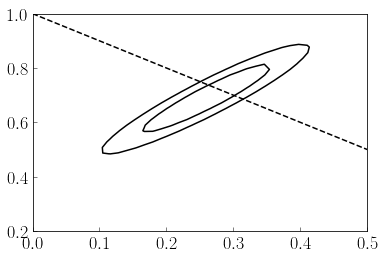

In [76]:
contour(Om, OL, chi2_scan, levels=[2.3, 6], colors="k")
plot(Om,1-Om,"k--")

In [92]:
def lnprob(pars):
    H0 = pars[0]
    Om = pars[1]
    OL = pars[2]
    return -0.5*chi2(H0, Om, OL)

In [172]:
ndim, nwalkers = 3, 50
Om0 = 0.3 + 0.01*random.randn(nwalkers)
OL0 = 0.7 + 0.01*random.randn(nwalkers)
H0 = 70. + 0.01*random.rand(nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [173]:
pos, prob, state = sampler.run_mcmc(sp.array([H0, Om0, OL0]).T, 500)

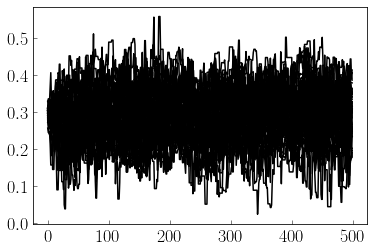

In [174]:
for i in range(nwalkers):
    plot(sampler.chain[i,:,1],"k")

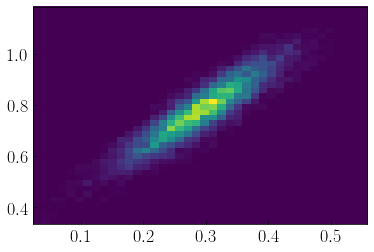

In [176]:
_=hist2d(sampler.chain[:,50:,1].flatten(), sampler.chain[:,50:,2].flatten(), bins=40)

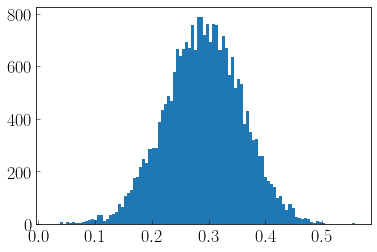

In [177]:
_=hist(sampler.chain[:,20:,1].flatten(), bins=100)

In [178]:
samples = sampler.chain[:,10:,:].reshape([-1, ndim])

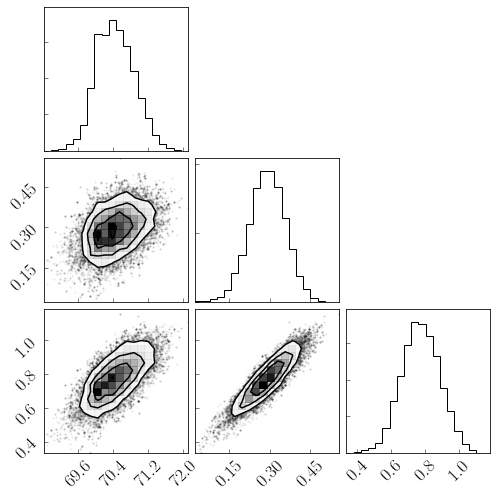

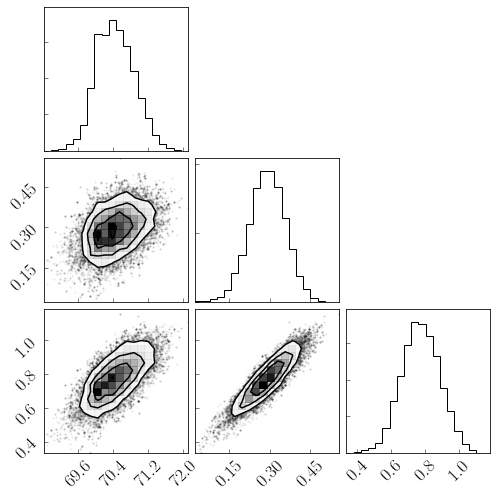

In [179]:
corner.corner(samples[:,:])